In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# **Utilities**

In [2]:
def color_treatment(img, plot=False):
    """
    Takes RGB or RGBA image then transforms then to grayscale, thresholds it, and inverts colors if needed.
    Uses opencv.
    Inputs:
        img -> ndarray : the image to be processed. Can be RGB or RGBA. Needs to be read by opencv.
        plot -> boolean : optional flag to plot image after fixing colors.
    Output:
        ndarray holding the resulted image.
    """
    # convert to grayscale
    gray = img
    if len(img.shape) >= 3:  # handle if image is RGB or RGBA
        rgb_img = img[:, :, :3]  # to ignore the A channel if it's RGBA
        gray = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2GRAY)

    # median filter to reduce salt and pepper in extreme cases
    median = cv2.medianBlur(gray, 3)

    # gaussian blur and otsu threshold to treat salt and pepper and binarize the image
    gaussian = cv2.GaussianBlur(median, (5, 5), 0)
    thresholded = cv2.threshold(
        gaussian, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    # now the image is grayscale we need to standardize the text color using the 4 corners (to avoid if one has salt and pepper)
    standard = thresholded
    right = thresholded.shape[0]-1
    bottom = thresholded.shape[1]-1
    if (int(thresholded[0, 0]) + int(thresholded[right, bottom]) + int(thresholded[0, bottom]) + int(thresholded[right, 0])) / 4 >= 127:  # 2 corners are white
        # int is used to avoid overflow in addition (max value is 255)
        standard = cv2.bitwise_not(thresholded)

    if plot:
        plt.imshow(standard , cmap="gray")
        plt.show()

    return standard

In [3]:
def get_text_points(image, pad=True, threshold=15, plot=False):
    """
    Takes a binary image to select only the points representing the text and ignore small contours are may be noise.
    Uses opencv.
    Inputs:
        image -> ndarray : a binary image containing text with noise.
        pad -> boolean : optional parameter to extend the boundaries of the image or not.
        threshold -> integer : optional parameter that can change the threshold of the number of points in a contour to be removed.
        plot -> boolean : optional flag to plot image with bounding rectangles for contours.
    Output:
        points-> ndarray : contains all the points that represent text.
        textContours -> ndarray : array of contours that contain text only.
        padded_image -> ndarray : a padded version of the image if pad is set to true.
    """
    padded_image = np.copy(image)
    if pad:
        padded_image = np.zeros((image.shape[0]*2, image.shape[1]*2), np.uint8)
        padded_image[image.shape[0]//2:image.shape[0]*3//2,
                     image.shape[1]//2:image.shape[1]*3//2] = image

    contours, _ = cv2.findContours(
        padded_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    textContours = [cnt for cnt in contours if len(cnt) >= threshold]

    points = []

    for contour in textContours:
        x, y, w, h = cv2.boundingRect(contour)
        points.append([x, y])
        points.append([x+w, y+h])

    if plot:
        text_contours_plot = np.copy(padded_image)

        for contour in textContours:
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(text_contours_plot, pt1=(x, y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=2)

        plt.figure(figsize=(12, 10))
        plt.imshow(text_contours_plot, cmap='gray')

    return np.array(points), textContours, padded_image

In [4]:
def tri_angle_area(points, image=None, plot=False, verbose=False, vertices=False):
    """
    Takes points bounding the text to find the triangle that fits these points and calculate its area and the angle at which the text is rotated.
    Uses opencv.
    Inputs:
        points-> ndarray : points that surround the text.
        image -> ndarray : optional parameter that has the image (used for plotting).
        plot -> boolean : optional flag to plot the enclosing triangle. (needs the image parameter).
        verbose -> boolean : optional flag to show info about the resulting triangle.
        vertices -> boolean : optional flag to output the triangle vertices.
    Output:
        angle -> float : angle at which the text is rotated.
        area -> float : area of the triangle.
        vert -> list : optional output that holds the triangle vertices.

    """
    triangle = cv2.minEnclosingTriangle(points)
    x = [triangle[1][0][0][0], triangle[1][1][0][0], triangle[1][2][0][0]]
    y = [triangle[1][0][0][1], triangle[1][1][0][1], triangle[1][2][0][1]]
    lengths = []

    angle = 0
    for i in range(3):
        dx = x[i] - x[(i+1) % 3]
        dy = y[i] - y[(i+1) % 3]

        lengths.append(np.sqrt(dx**2 + dy**2))

        # TODO: if it's not a right angle triangle
        if abs(dx) >= 50 and abs(dy) >= 50:
            angle = dy/dx

    angle = np.degrees(np.arctan(angle))

    if abs(angle) > 80 or abs(angle) < 5:
        angle = 0

    s = np.sum(lengths) / 2
    # Calculate area using Heron's formula
    area = np.sqrt(s * (s - lengths[0]) * (s - lengths[1]) * (s - lengths[2]))

    if plot:
        plt.imshow(image, cmap ="gray")
        plt.plot(x, y, color='green', linewidth=2)
        # plt.axis('off')
        plt.show()
    
    if verbose:
        print("triangle area:", area)
        print("triangle angle:", angle)
        print("triangle sides:", lengths)

    if vertices:
        return angle, area, [ [x[0], y[0]], [x[1], y[1]], [x[2], y[2]]]
    return angle, area

In [5]:
def rect_angle_area(points, image=None, plot=False, verbose=False, vertices=False):
    """
    Takes points bounding the text to find the rectangle that fits these points and calculate its area and the angle at which the text is rotated.
    Uses opencv.
    Inputs:
        points-> ndarray : points that surround the text.
        image -> ndarray : optional parameter that has the image (used for plotting).
        plot -> boolean : optional flag to plot the enclosing rectangle. (needs the image parameter).
        verbose -> boolean : optional flag to show info about the resulting rectangle.
        vertices -> boolean : optional flag to output the rectangle vertices.
    Output:
        angle -> float : angle at which the text is rotated.
        area -> float : area of the rectangle.
        box -> list : optional output that holds the rectangle vertices.
    """
    rect = cv2.minAreaRect(points)
    angle = rect[-1]

    if abs(angle) > 80 or abs(angle) < 5:
        angle = 0

    box = cv2.boxPoints(rect)

    # TODO: handle when it's 90 degrees already

    sorted_indices = np.argsort(box[:, 1])  # Sort based on y
    vert = box[sorted_indices]
    
    w = np.sqrt((vert[0,0] - vert[1,0]) **2 + (vert[0,1] - vert[1,1]) **2)
    h = np.sqrt((vert[0,0] - vert[2,0]) **2 + (vert[0,1] - vert[2,1]) **2)

    area = w * h

    if plot:
        plt.imshow(image, cmap='gray')
        plt.plot(box[:, 0], box[:, 1], color='green', linewidth=2)
        # plt.axis('off')
        plt.show()

    if verbose:
        print("rectangle area:", area)
        print("rectangle angle:", angle)
        print("rectangle vertices:", box)
        print("rectangle w, h:", w,h)
    
    if vertices:
        return angle, area, box

    return angle, area

In [6]:
def skew_treatment(image, plot=False, verbose=False):
    """
    Takes a binary image to find the angle needed to fix the skew of the image.
    Uses opencv.
    Inputs:
        image -> ndarray : The image to be processed. Needs to be a binary image. Needs to be read by opencv.
        plot -> boolean : optional flag to plot the original & the rotated image.
        verbose -> boolean : optional flag to show info about the rotation process.
    Output:
        rotated -> ndarray : holding the rotated image.
    """
    points, _, padded = get_text_points(image)

    rect_angle, rect_area = rect_angle_area(points, verbose=verbose)
    tri_angle, tri_area = tri_angle_area(points, verbose=verbose)

    # TODO: condition isn't working right

    (h, w) = padded.shape[:2]
    center = np.mean(points, axis=0)

    angle = rect_angle
    if rect_area > tri_area:
        angle= tri_angle

    M = cv2.getRotationMatrix2D(center, -angle, 1.0)
    rotated = cv2.warpAffine(padded, M, (w, h),
        flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    rotated = rotated[ rotated.shape[0]//4: rotated.shape[0]*3//4,
                      rotated.shape[0]//4: rotated.shape[1]*3//4]

    if plot:
        plt.imshow(padded)
        plt.title("Padded")
        plt.show()
        plt.imshow(rotated)
        plt.title("Rotated")
        plt.show()

    if verbose:
        if rect_area > tri_area:
            print("used triangle angle")
        else:
            print("used rectangle angle")

    return rotated

# **Experimenting**

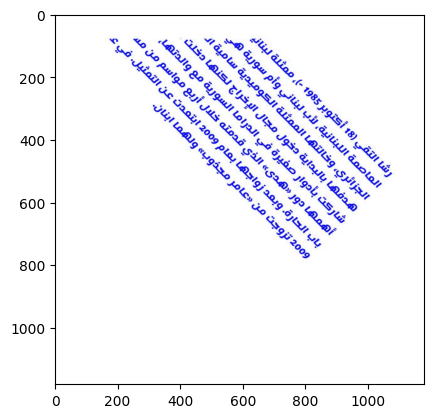

In [7]:
img = cv2.imread("fonts-dataset/Lemonada/13.jpeg")

## Lemonada
# 3 15 47 74        S&P noise
# 234               inverted
# 4 13 42 38        rotated

plt.imshow(img)
plt.show()

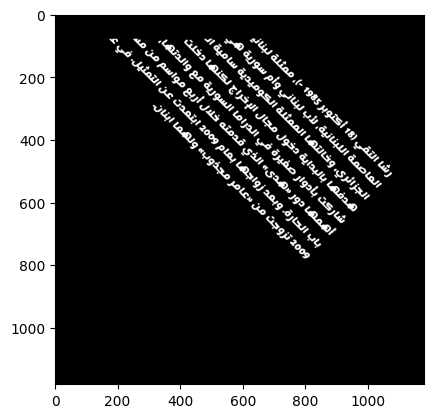

In [8]:
color_fixed = color_treatment(img)
plt.imshow(color_fixed, cmap="gray")
plt.show()

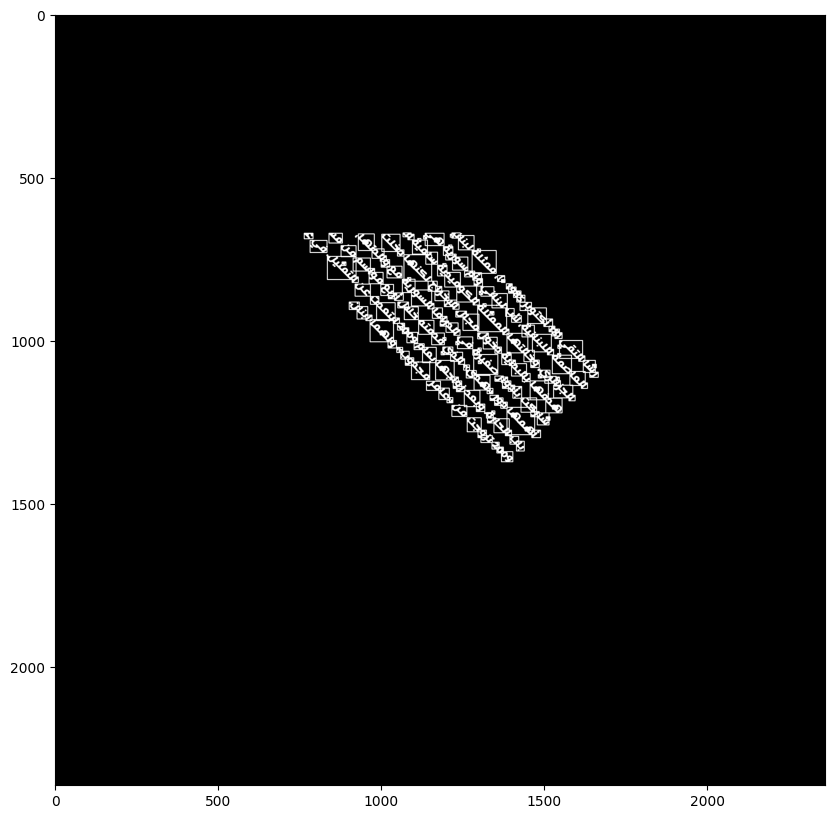

In [9]:
points, textContours, padded = get_text_points(color_fixed, True, plot=True)

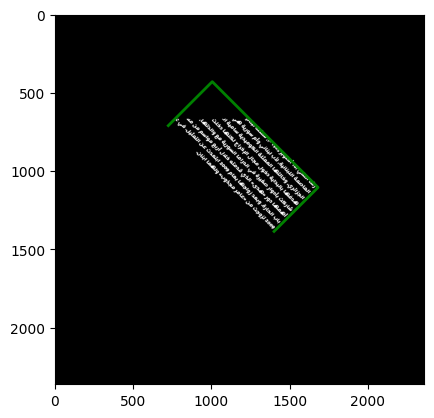

rectangle area: 379912.0
rectangle angle: 45.0
rectangle vertices: [[ 724.5001   708.5001 ]
 [1005.5001   427.50012]
 [1681.5001  1103.5001 ]
 [1400.5001  1384.5001 ]]
rectangle w, h: 397.39401102683973 956.0083681642122


In [10]:
rect_angle, rect_area = rect_angle_area(points, padded, True, True)

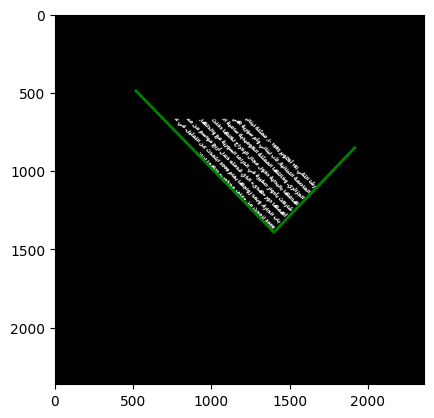

triangle area: 471432.75691512995
triangle angle: 14.572199
triangle sides: [1262.1132454232804, 747.5002943016657, 1444.4455921185936]


In [11]:
tri_angle, tri_area = tri_angle_area(points, padded, True, True)

rectangle area: 379912.0
rectangle angle: 45.0
rectangle vertices: [[ 724.5001   708.5001 ]
 [1005.5001   427.50012]
 [1681.5001  1103.5001 ]
 [1400.5001  1384.5001 ]]
rectangle w, h: 397.39401102683973 956.0083681642122
triangle area: 471432.75691512995
triangle angle: 14.572199
triangle sides: [1262.1132454232804, 747.5002943016657, 1444.4455921185936]


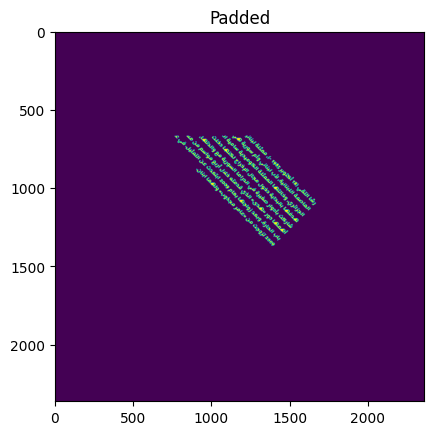

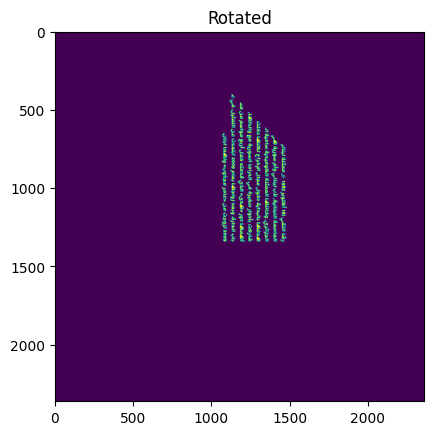

used rectangle angle


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [13]:
img = cv2.imread("fonts-dataset/Lemonada/13.jpeg")

# Lemonada
# 3 15 47 74        S&P noise
# 234               inverted
# 4 13 42 38        rotated

skew_treatment(color_treatment(img), True, True)

# **Testing the count of black pixels inside the bounding polygon**
## Triangle

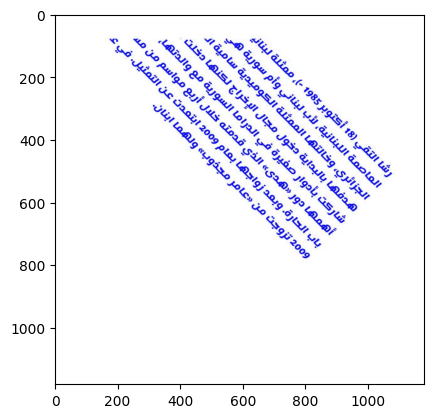

In [48]:
test1 = cv2.imread("fonts-dataset/Lemonada/13.jpeg")
plt.imshow(test1)
plt.show()

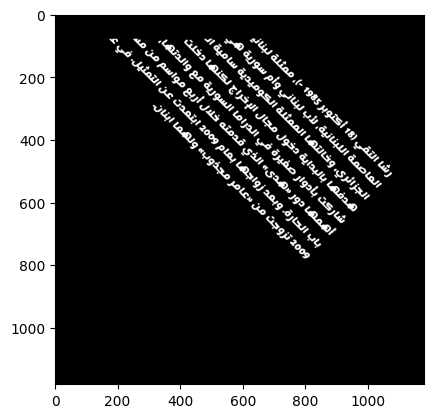

In [49]:
test1 = color_treatment(test1, True)

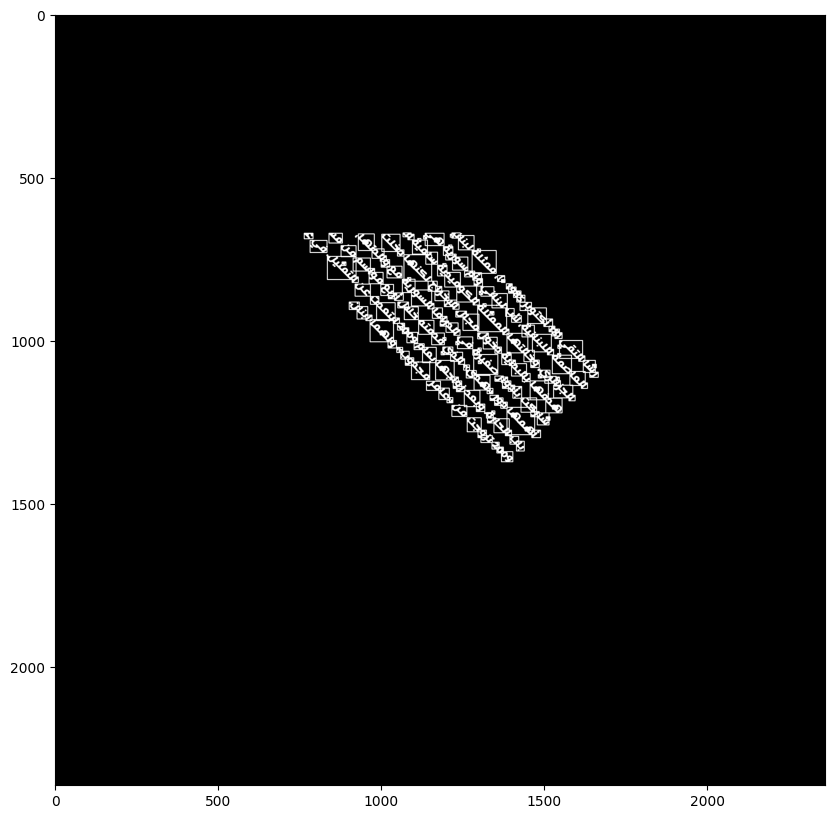

In [50]:
points,_, test1p = get_text_points(test1, plot=True)

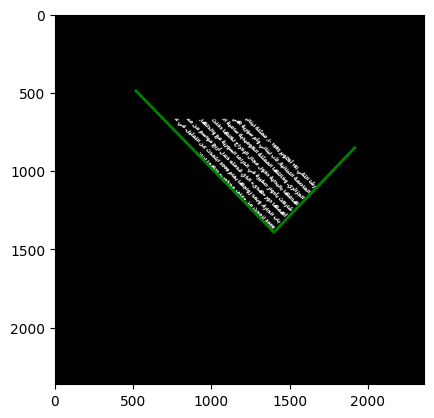

array([[ 518,  486],
       [1399, 1389],
       [1915,  849]])

In [51]:
_,_, tri_vert = tri_angle_area(points, test1p, True, False, True)
tri_vert = np.array(tri_vert, np.int32)
tri_vert

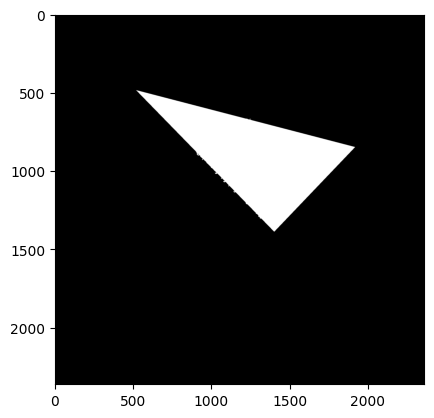

In [53]:
mask = np.copy(test1p)
cv2.fillPoly(mask, [tri_vert.reshape((-1, 1, 2))], color=(255,255,255))
plt.imshow(mask, cmap="gray")
plt.show()

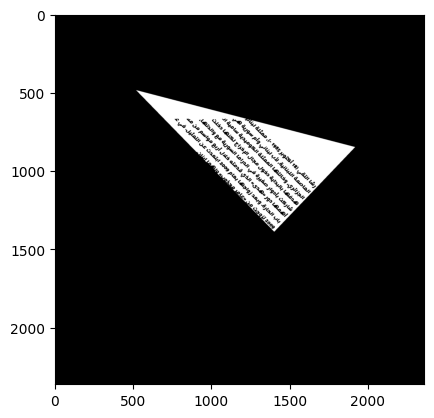

In [54]:
test1inv = cv2.bitwise_not(test1p)

test1masked = cv2.bitwise_and(test1inv, mask)

plt.imshow(test1masked, cmap="gray")
plt.show()

In [55]:
test1maskednorm = np.divide(test1masked, 255)
maskedarea = test1maskednorm.sum()
maskedarea

401411.0

## Rectangle

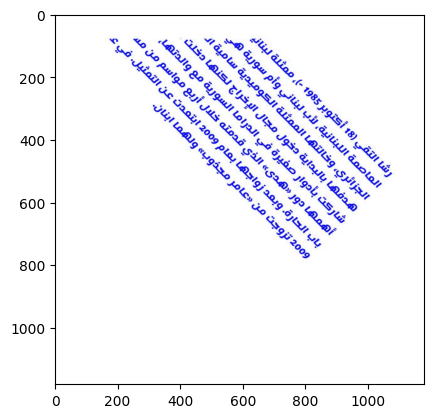

In [56]:
test2 = cv2.imread("fonts-dataset/Lemonada/13.jpeg")
plt.imshow(test2)
plt.show()

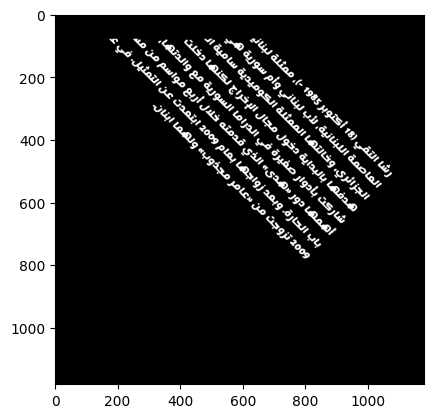

In [57]:
test2 = color_treatment(test2, True)

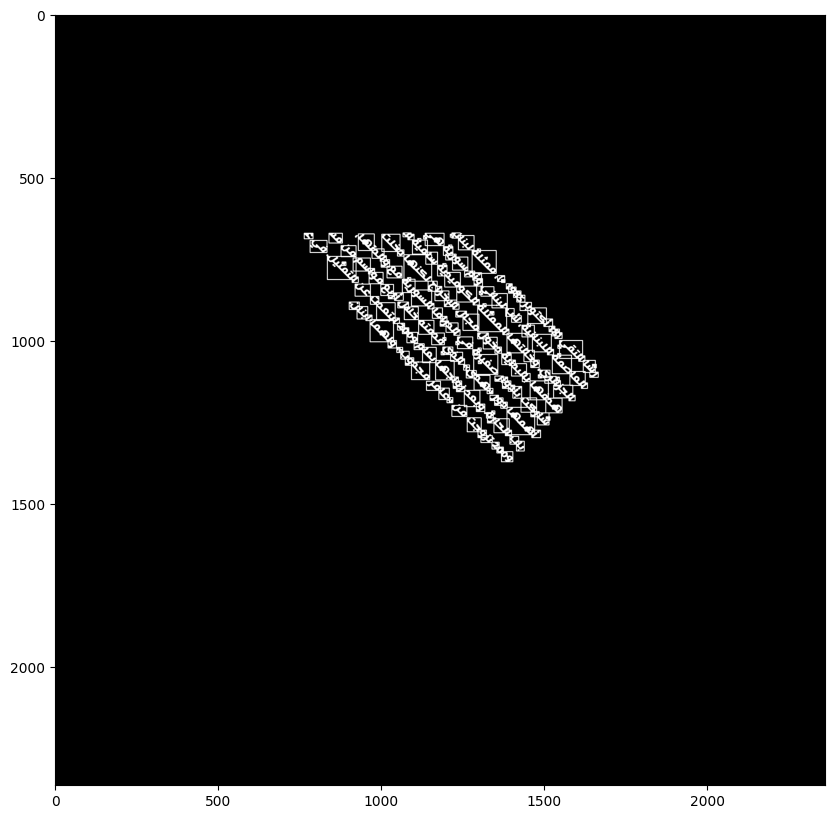

In [58]:
points2,_, test2p = get_text_points(test2, plot=True)

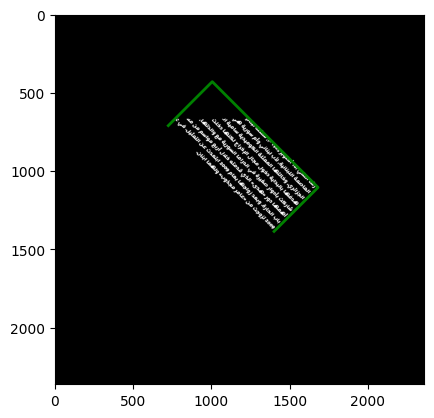

array([[ 724,  708],
       [1005,  427],
       [1681, 1103],
       [1400, 1384]])

In [59]:
_,_, rect_vert = rect_angle_area(points2, test2p, True, False, True)
rect_vert = np.array(rect_vert, np.int32)
rect_vert

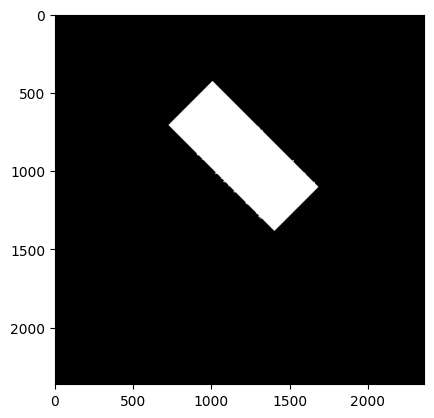

In [60]:
mask2 = np.copy(test2p)
cv2.fillPoly(mask2, [rect_vert.reshape((-1, 1, 2))], color=(255,255,255))
plt.imshow(mask2, cmap="gray")
plt.show()

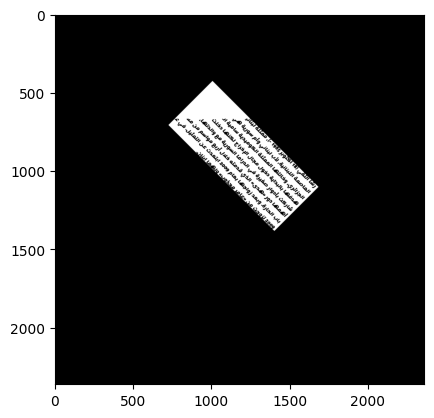

In [61]:
test2inv = cv2.bitwise_not(test2p)

test2masked = cv2.bitwise_and(test2inv, mask2)

plt.imshow(test2masked, cmap="gray")
plt.show()

In [62]:
test2maskednorm = np.divide(test2masked, 255)
masked2area = test2maskednorm.sum()
masked2area

309960.0